This code reads the SLUG models from Krumholz et al. 2015, and it reads the tottal ionizing flux Qo, mass, age, and Av of the clusters in the library
It makes a mapping between cluster mass and H-alpha luminosity (via Qo) and it integrates the cluster mass function above a limiting mass corresponding
to the minimum HII region luminosity in Santoro et al. 2022.

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import scipy.interpolate as interpolate
import seaborn as sns

In [221]:
# Read SLUG models

phot=fits.open('../slug/modp020_chabrier_MW_cluster_phot.fits')
prop=fits.open('../slug/modp020_chabrier_MW_cluster_prop.fits')

#phot=fits.open('../slug/kafc18/kafc18_cluster_phot.fits')
#prop=fits.open('../slug/kafc18/kafc18_cluster_prop.fits')

#phot[2].header
#for i in range(len(phot)):
#    if i!=0:
#        print(i, phot[i].data.columns)
#print(len(phot))

age=prop[1].data['Time']
mass=prop[1].data['LiveMass']
av=prop[1].data['A_V']
q0=np.array(phot[2].data).astype(float)
fesc=0.5
lha=(1.37e-12)*q0*fesc  # using equation from Calzetti et al.

In [222]:
# Read Santoro et al. 2022 minimum L(Ha) for each galaxy

galaxies=np.array(["NGC3627","NGC1087","NGC4321","NGC4254","NGC1566","NGC1512","NGC3351","NGC0628","NGC4535","NGC1385","NGC1365","NGC1433","NGC1300"])
#lhamin={"NGC3627":37.43 ,"NGC1087":37.49 ,"NGC4321":37.95 ,"NGC4254":37.36 ,"NGC1566":37.14 ,"NGC1512":37.41 ,"NGC3351":36.84 ,"NGC0628":36.63 ,"NGC4535":36.79 ,"NG1385":37.29 ,"NGC1365":37.82 ,"NGC1433":37.32 ,"NGC1300":37.08}
lhamin=np.array([37.43,37.49,37.95,37.36,37.14,37.41,36.84,36.63,36.79,37.29,37.82,37.32,37.08])


In [223]:
# Get mapping between L_Halpha and M_cluster from SLUG models. Assuming vissible HII regions correspond to clusters with ....

lhamin0=1e33 # minimum luminosity models to consider
lhamax0=1e41 # maximum luminosity models to consider

sel0=(age>2.9e6)*(age<3.1e6)*(lha>lhamin0)*(lha<lhamax0)
sel1=(age<7e6)*(lha>lhamin0)*(lha<lhamax0)
#sel0=(age>3e6)*(age<7e6)*(av<2)*(mass>=mcmin)*(mass<=mcmax)
#sel=(age>1e6)*(age<9e6)*(av<2)*(np.log10(lha)>lcom)*(np.log10(lha)<lmax)

dbin=0.25
lhabins=np.arange(np.log10(lhamin0), np.log10(lhamax0), dbin)+dbin/2
mbins=np.zeros_like(lhabins)
sigmambins=np.zeros_like(lhabins)

for i in range(len(lhabins)):
    binsel=(np.log10(lha[sel0])>lhabins[i]-dbin/2)*(np.log10(lha[sel0])<lhabins[i]+dbin/2)
    mbins[i]=np.median(np.log10(mass[sel0][binsel]))
    sigmambins[i]=np.std(np.log10((mass[sel0][binsel])))
    
f=interpolate.interp1d(lhabins, mbins, bounds_error=False)
sf=interpolate.interp1d(lhabins, sigmambins, bounds_error=False)



In [224]:
# Calculate Mlim and eMlim for each galaxy

mlim=np.zeros_like(lhamin)
emlim=np.zeros_like(lhamin)


for i in range(len(galaxies)):
    mlim[i]=f(lhamin[i])
    emlim[i]=sf(lhamin[i])


print(lhamin, mlim, emlim)

[37.43 37.49 37.95 37.36 37.14 37.41 36.84 36.63 36.79 37.29 37.82 37.32
 37.08] [3.26778534 3.29871216 3.65056741 3.22603028 3.02941665 3.2574764
 2.75770576 2.70322183 2.74473339 3.16347139 3.53133932 3.19028234
 2.97115071] [0.29992002 0.31872841 0.26769539 0.28334189 0.29306418 0.29365056
 0.32954455 0.32198    0.32774347 0.28643534 0.30836204 0.28510958
 0.30040115]


In [225]:
# Calculate Nprior and eNpiror for each galaxy

mcmax=1e6 # max and min cluster mass allowed, for integration of cluster mass function
mcmin=1e2
sfe=0.025 # integrated star formation efficiency 

# Read median GMC mass for each galaxy
#mgmc=3.56e6

mgmc=np.zeros_like(lhamin)
fhg=np.zeros_like(lhamin)
for i in range(len(galaxies)):
    file=open('./output/'+galaxies[i]+'_fhg.txt')
    data=file.readlines()
    mgmc[i]=float(data[4].split()[1])
    fhg[i]=float(data[0].split()[1])
    


A=mgmc*sfe/np.log(mcmax/mcmin)
Nprior=A*(1/10**mlim-1/mcmax)
lNprior=Nprior-A*(1/10**(mlim+emlim)-1/mcmax)
uNprior=A*(1/10**(mlim-emlim)-1/mcmax)-Nprior
eNprior=0.5*(lNprior+uNprior)

for i in range(len(galaxies)):
    print(galaxies[i], fhg[i], Nprior[i], eNprior[i])




NGC3627 1.4464788732394367 5.200468398128418 3.8909582031375267
NGC1087 3.588516746411483 3.5098806808718646 2.8190479948768905
NGC4321 1.3954285714285715 1.5948772184025033 1.0512145911575492
NGC4254 3.15748031496063 7.251259874523706 5.082241394126919
NGC1566 1.8333333333333333 9.020784808903791 6.566918607501577
NGC1512 2.1310344827586207 3.2913378733150847 2.4032972383115543
NGC3351 7.510869565217392 7.943009051692219 6.626257865692891
NGC0628 11.427230046948356 12.325715333998577 10.00361140557716
NGC4535 3.662269129287599 10.720493126459173 8.885313658148245
NGC1385 2.6224899598393576 4.57127135467886 3.243054318528596
NGC1365 0.32605729877216916 5.908087891447084 4.571923091370117
NGC1433 2.7523364485981308 4.692170981920632 3.311569512875978
NGC1300 1.836734693877551 6.4701473288751 4.845438875697804


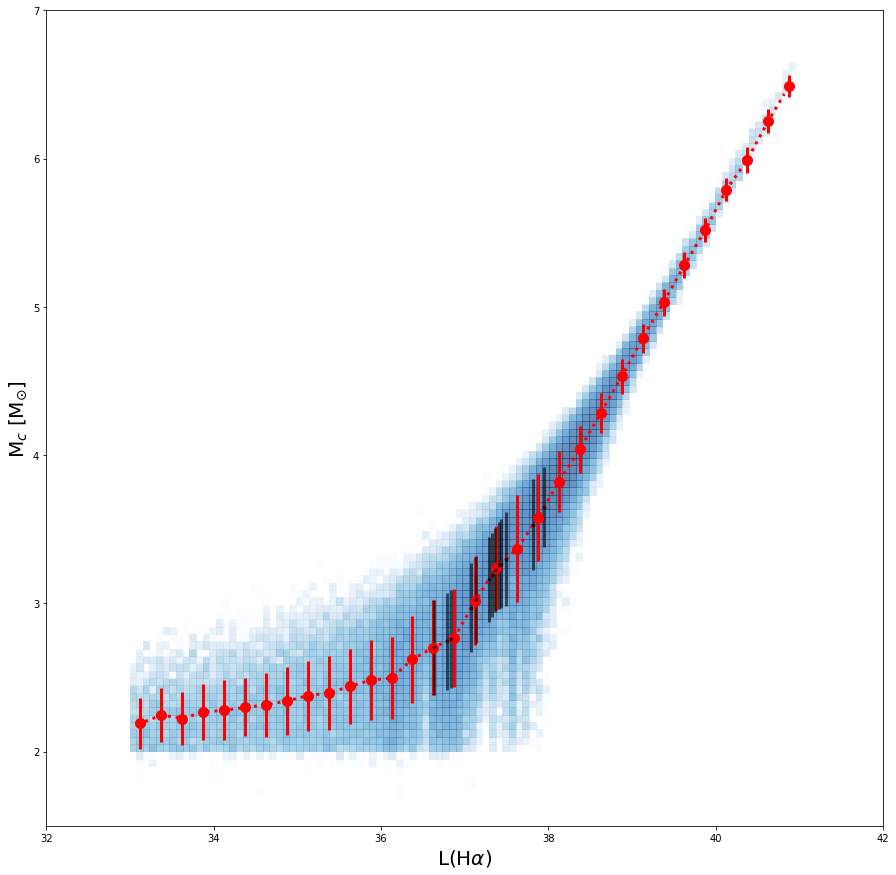

[33.125 33.375 33.625 33.875 34.125 34.375 34.625 34.875 35.125 35.375
 35.625 35.875 36.125 36.375 36.625 36.875 37.125 37.375 37.625 37.875
 38.125 38.375 38.625 38.875 39.125 39.375 39.625 39.875 40.125 40.375
 40.625 40.875] [2.19094499 2.24675819 2.22323486 2.26737751 2.27882577 2.29848363
 2.31509969 2.34180227 2.3780592  2.39621412 2.43999726 2.48313403
 2.49607041 2.62380054 2.70192459 2.76678641 3.01601117 3.23943575
 3.3682975  3.57732547 3.82146529 4.03978801 4.28437198 4.53149387
 4.78771599 5.03103883 5.28213669 5.51977643 5.78996948 5.99292238
 6.2517011  6.49077472] [0.16979322 0.17979251 0.17951101 0.18869554 0.20307663 0.19525675
 0.21425206 0.23035893 0.23673693 0.25043553 0.25553045 0.27024221
 0.27817888 0.29248136 0.32179989 0.33080531 0.29372707 0.282679
 0.36104727 0.2935021  0.20747972 0.15996416 0.13717304 0.1159433
 0.09795746 0.09027672 0.09048234 0.08184532 0.07832029 0.08863685
 0.08122313 0.07396377]
[33.         33.09090909 33.18181818 33.27272727 33.3636

In [226]:
# Make Plots

xaux=np.linspace(33, 42, 100)
yaux=f(xaux)

fig1,ax1=plt.subplots(figsize=(15, 15))
#ax1.plot(np.log10(lha[sel0]), np.log10(mass[sel0]), '.', alpha=0.1, color='grey')
ax1.hist2d(np.log10(lha[sel0]), np.log10(mass[sel0]), bins=100, norm=matplotlib.colors.LogNorm(),  cmap=plt.get_cmap('Blues'), alpha=0.6)
#ax1.hist2d(np.log10(lha[sel1]), np.log10(mass[sel1]), bins=100, norm=matplotlib.colors.LogNorm(),  cmap=plt.get_cmap('Oranges'), alpha=0.2)
#for i in range(len(lhamin)):
#    ax1.axvline(x=lhamin[i], color='cyan', alpha=0.7)
ax1.errorbar(lhabins, mbins, yerr=sigmambins, color='red', elinewidth=3, fmt='.', alpha=1)
ax1.plot(lhabins, mbins, 'o', color='red', markersize=10, alpha=1)
ax1.plot(xaux, yaux, color='red', linewidth=3, linestyle=':', alpha=1)
ax1.errorbar(lhamin, mlim, yerr=emlim, color='black', elinewidth=3, fmt='.', alpha=0.6)
ax1.set_xlabel(r'L(H$\alpha$)', fontsize=20)
ax1.set_ylabel(r'M$_{c}$ [M$_{\odot}$]', fontsize=20)
ax1.set_xlim(32, 42)
ax1.set_ylim(1.5, 7)
plt.show()

print(lhabins, mbins, sigmambins)

print(xaux, yaux)

